In [101]:
# !pip install pykalman
# !pip install ffn

In [102]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import ffn
from pykalman import KalmanFilter
import seaborn as sns

In [103]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['MSFT', 'ADBE']

df = yf.download(tickers, start, end)['Close']
df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2013-01-02,38.340000,27.620001
2013-01-03,37.750000,27.250000
2013-01-04,38.130001,26.740000
2013-01-07,37.939999,26.690001
2013-01-08,38.139999,26.549999


In [104]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

##########################################################################################

def KalmanFilterRegression(x, y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)  # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,  # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    # Handle potential numerical issues using try-except block
    try:
        state_means, state_covs = kf.filter(y.values)
    except ValueError as e:
        print(f"Error encountered during Kalman Filter estimation: {e}")
        # Handle the error, e.g., by returning NaNs or alternative values
        state_means = np.full((len(y), 2), np.nan)  # Replace with desired error handling
        state_covs = np.full((len(y), 2, 2), np.nan)

    return state_means, state_covs  # Return both state_means and state_covs

In [105]:
state_means, state_covs = KalmanFilterRegression(KalmanFilterAverage(df['ADBE']), KalmanFilterAverage(df['MSFT']))
print(state_means)

[[0.68133077 0.68133077]
 [0.68978144 0.68844597]
 [0.69009625 0.68862539]
 ...
 [0.44962344 0.71308942]
 [0.44935271 0.71308373]
 [0.44902089 0.71307993]]


In [106]:
print(state_covs)

[[[ 4.89202203e-03  4.89202203e-03]
  [ 4.89202203e-03  4.89202203e-03]]

 [[ 1.94334265e-03  1.56651298e-03]
  [ 1.56651298e-03  3.09304698e-03]]

 [[ 1.30424261e-03  6.31817300e-04]
  [ 6.31817300e-04  3.56136372e-03]]

 ...

 [[ 6.54098419e-05 -6.58188940e-03]
  [-6.58188940e-03  1.50914184e+00]]

 [[ 6.57554875e-05 -6.60291656e-03]
  [-6.60291656e-03  1.51014240e+00]]

 [[ 6.59090815e-05 -6.61436364e-03]
  [-6.61436364e-03  1.51114327e+00]]]


In [107]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(state_covs[5]*1000, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
# plt.title("Heatmap of Covariance Matrix")
# plt.xlabel("Features")
# plt.ylabel("Features")
# plt.show()

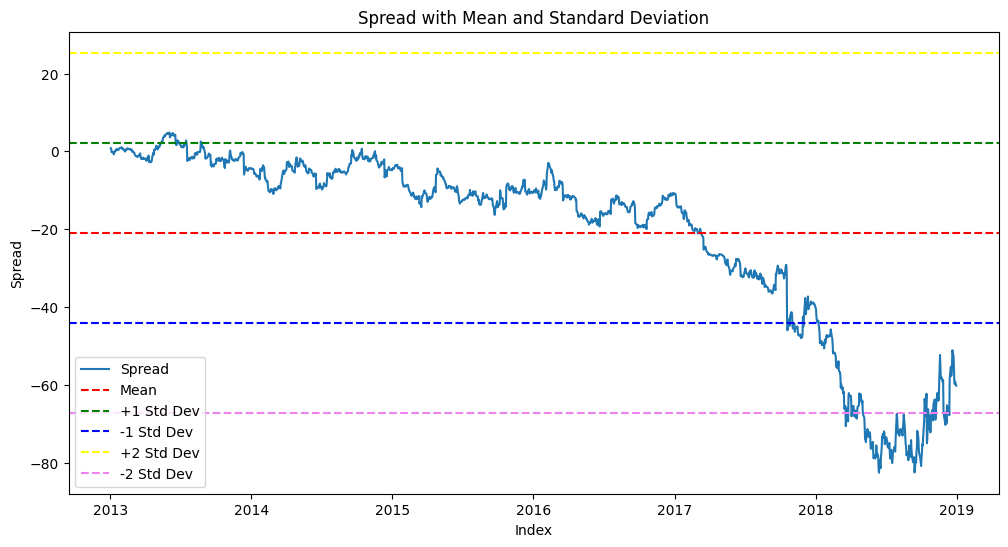

In [108]:
# Calculate spread
df['spread'] = df['MSFT'] - state_means[:, 0] - df['ADBE'] * state_means[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(df['spread'], label='Spread')

spread_mean = df['spread'].mean()
spread_std = df['spread'].std()

plt.axhline(spread_mean, color='red', linestyle='--', label='Mean')
plt.axhline(spread_mean + spread_std, color='green', linestyle='--', label='+1 Std Dev')
plt.axhline(spread_mean - spread_std, color='blue', linestyle='--', label='-1 Std Dev')
plt.axhline(spread_mean + 2*spread_std, color='yellow', linestyle='--', label='+2 Std Dev')
plt.axhline(spread_mean - 2*spread_std, color='violet', linestyle='--', label='-2 Std Dev')

plt.title('Spread with Mean and Standard Deviation')
plt.xlabel('Index')
plt.ylabel('Spread')
plt.legend()
plt.show()

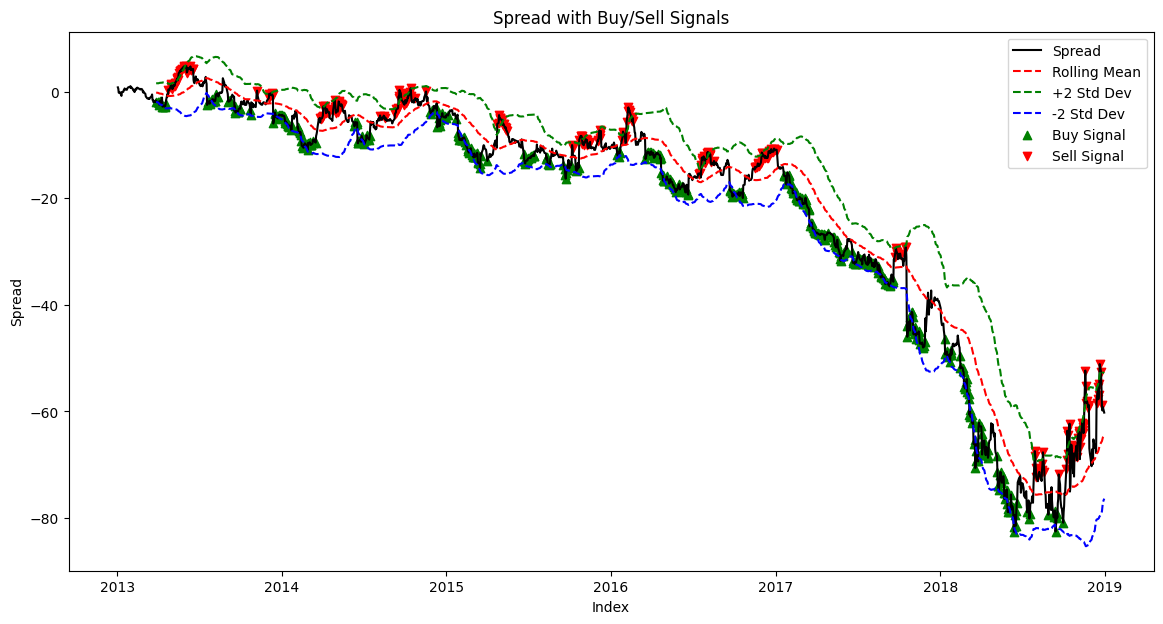

In [109]:
# Backtesting with a 60 day lookback period
rolling_window = 60
df['spread_mean'] = df['spread'].rolling(rolling_window).mean()
df['spread_std'] = df['spread'].rolling(rolling_window).std()

# Generating Trading Signals
df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']
df['signal'] = 0  # Initialize signal column
df['Sell_signal'] = (df['z_score'] > 1) # Sell signal
df['Buy_signal'] = (df['z_score'] < -1)  # Buy signal

# Plotting Spread and Signals
plt.figure(figsize=(14, 7))
plt.plot(df['spread'], label='Spread', color='black')
plt.plot(df['spread_mean'], label='Rolling Mean', color='red', linestyle='--')
plt.plot(df['spread_mean'] + 2 * df['spread_std'], label='+2 Std Dev', color='green', linestyle='--')
plt.plot(df['spread_mean'] - 2 * df['spread_std'], label='-2 Std Dev', color='blue', linestyle='--')

buy_signals = df[df['Buy_signal'] == 1]
sell_signals = df[df['Sell_signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['spread'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['spread'], marker='v', color='red', label='Sell Signal', alpha=1)


plt.title('Spread with Buy/Sell Signals')
plt.xlabel('Index')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [110]:
df['PnL'] = 0
positions1 = {'ADBE': 0, 'MSFT': 0}

for i in range(len(df)):
    idx = df.index[i]  # Get the actual index value

    if df.loc[idx, 'Buy_signal']:  # Use loc with the index value
        positions1['ADBE'] += 10
        positions1['MSFT'] -= 10
    elif df.loc[idx, 'Sell_signal']:
        positions1['ADBE'] -= 10
        positions1['MSFT'] += 10

    df.loc[idx, 'PnL'] = positions1['ADBE'] * df.loc[idx, 'ADBE'] + positions1['MSFT'] * df.loc[idx, 'MSFT'] - 0.01*(df.loc[idx, 'ADBE'] + df.loc[idx, 'MSFT']) # assuming 0.1% tansaction costs on every trade

filtered_df1 = df[df['z_score'].notna()]

# Calculate PnL change
filtered_df1['PnL_Change'] = filtered_df1['PnL'].diff()

final_profit = filtered_df1['PnL'].iloc[-1]
print(filtered_df1[['PnL']])


<ipython-input-110-6da5a59ea065>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.6596000099182129' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'PnL'] = positions1['ADBE'] * df.loc[idx, 'ADBE'] + positions1['MSFT'] * df.loc[idx, 'MSFT'] - 0.01*(df.loc[idx, 'ADBE'] + df.loc[idx, 'MSFT']) # assuming 0.1% tansaction costs on every trade


Ticker                PnL
Date                     
2013-03-28     148.378698
2013-04-01     294.680109
2013-04-02     450.773477
2013-04-03     604.877452
2013-04-04     779.771835
...                   ...
2018-12-24  321984.025685
2018-12-26  353703.863136
2018-12-27  358241.134154
2018-12-28  354715.380675
2018-12-31  360293.038657

[1451 rows x 1 columns]


<ipython-input-110-6da5a59ea065>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['PnL_Change'] = filtered_df1['PnL'].diff()


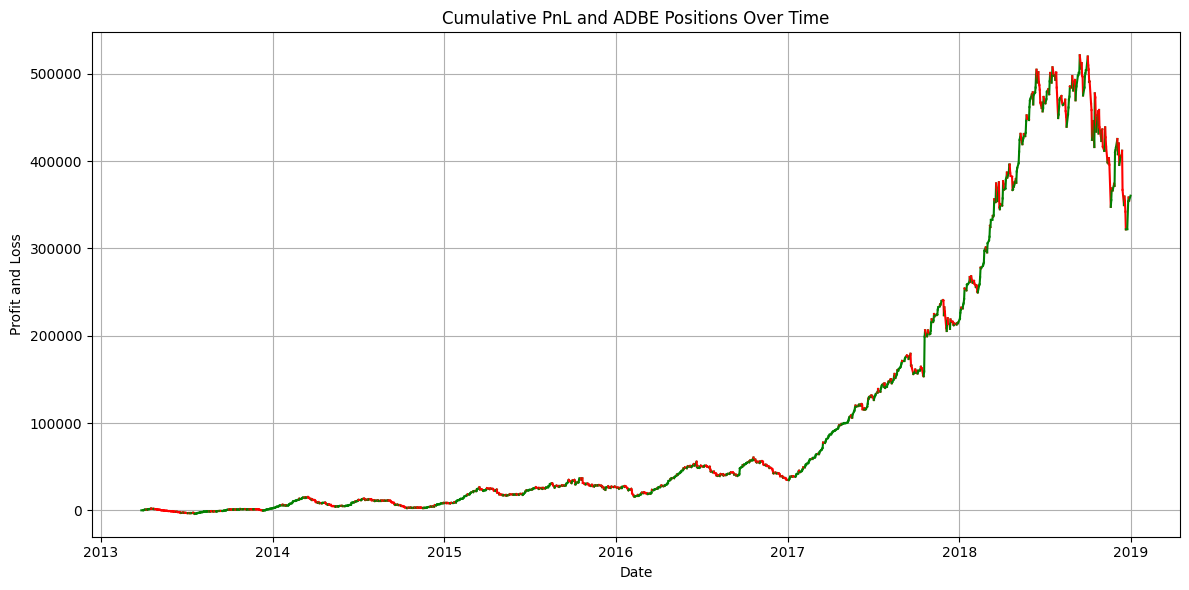

In [111]:
# Plot the PnL with color-coded segments
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(1, len(filtered_df1)):
    if filtered_df1['PnL_Change'].iloc[i] > 0:  # PnL is increasing
        ax1.plot(filtered_df1.index[i-1:i+1],
                 filtered_df1['PnL'].iloc[i-1:i+1],
                 color='green')
    else:  # PnL is decreasing
        ax1.plot(filtered_df1.index[i-1:i+1],
                 filtered_df1['PnL'].iloc[i-1:i+1],
                 color='red')

# Customize the primary y-axis
ax1.set_title("Cumulative PnL and ADBE Positions Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Profit and Loss")
ax1.tick_params(axis='y', labelcolor='black')

plt.tight_layout()
plt.grid()
plt.show()

In [112]:
print(f"Final profit is ${filtered_df1['PnL'].iloc[-1]:,.2f}")

Final profit is $360,293.04
